In [53]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from joblib import dump, load
import os
import seaborn as sns
from IPython.display import display

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, GridSearchCV

In [29]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

X_test = pd.read_csv('./data/X_test.csv')

In [30]:
print(X_train.shape)
print(X_train.columns)
print(y_train.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [31]:
X_train.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


In [32]:
# Concatenation
X = pd.concat([X_train, X_test])
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
print(f'Concate X Shape: {X.shape}')
X.head()

X Train Shape: (85751, 8)
X Test Shape: (36751, 8)
Concate X Shape: (122502, 8)


,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


In [33]:
parallel_procs = -1

In [34]:
# Standardize
sc_X = StandardScaler()
sc_X.fit(X.values)
X_std = pd.DataFrame(sc_X.fit_transform(X.values), columns=X.columns)
X_train_std = pd.DataFrame(sc_X.fit_transform(X_train.values), columns=X.columns)
X_test_std = pd.DataFrame(sc_X.fit_transform(X_test.values), columns=X.columns)

In [35]:
# row_num = 3
# col_num = 3
# _, subplot_arr = plt.subplots(col_num, row_num, figsize=(20, 20))

# for idx, x_var in enumerate(X_train.columns):
#     col_idx = idx % col_num
#     row_idx = idx // col_num

#     subplot_arr[row_idx, col_idx].scatter(X_train[x_var], y_train)
#     subplot_arr[row_idx, col_idx].set_xlabel(x_var)
# plt.show()

# Random Forest Feature Importance

Sort the feature in descending order of importance. Keep the order in indices_f.

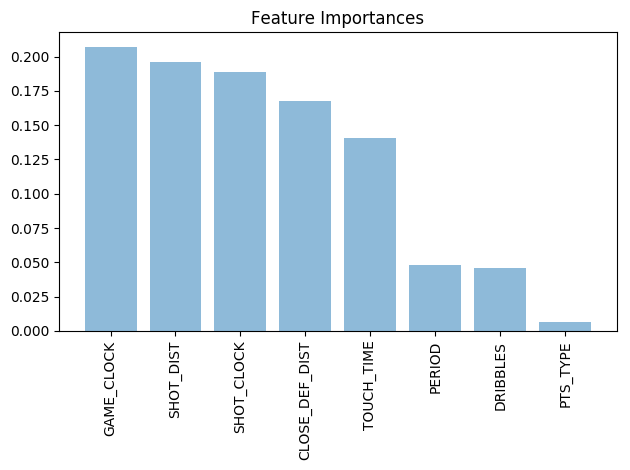

TOP 3 Fetures: GAME_CLOCK, SHOT_DIST, SHOT_CLOCK


In [36]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200,
                                random_state=1,
                                n_jobs=parallel_procs)
forest.fit(X_train_std, y_train.values.ravel())
importances = forest.feature_importances_
indices_f = np.argsort(importances)[::-1]

plt.title('Feature Importances')
plt.bar(range(importances.shape[0]), 
        importances[indices_f], 
        align='center', 
        alpha=0.5)
plt.xticks(range(importances.shape[0]),
           X_train.columns.values[indices_f],
           rotation=90)
plt.tight_layout()
plt.show()

print(f'TOP 3 Fetures: {X_train.columns.values[indices_f[0]]}, {X_train.columns.values[indices_f[1]]}, {X_train.columns.values[indices_f[2]]}')

# LASSO Feature Selection

Sort the feature in descending order of cofficients. Keep the order in indices_l.

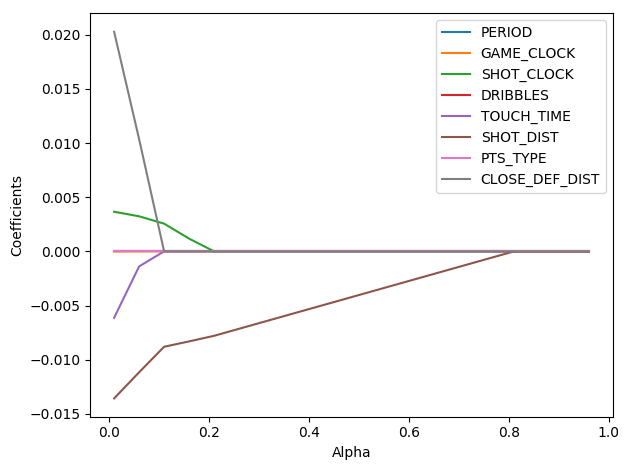

TOP 3 Fetures: CLOSE_DEF_DIST, SHOT_DIST, TOUCH_TIME


In [37]:
# alpha = 10
alpha_arr = np.arange(0.01, 1, 0.05)
feature_num = X.columns.values.shape[0]
coef = np.zeros((alpha_arr.shape[0], feature_num))

for idx in range(alpha_arr.shape[0]):
    lasso = Lasso(alpha=alpha_arr[idx])
    lasso.fit(X_train, y_train)
    coef[idx, :] = lasso.coef_.reshape(1, -1)

for coef_idx in range(lasso.coef_.shape[0]):
    plt.plot(alpha_arr, coef[:, coef_idx], label=X_train.columns.values[coef_idx])

plt.legend()
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.show()

indices_l = np.argsort(abs(coef[0]))[::-1]
print(f'TOP 3 Fetures: {X_train.columns.values[indices_l[0]]}, {X_train.columns.values[indices_l[1]]}, {X_train.columns.values[indices_l[2]]}')

# Variance of Features

Sort the feature in descending order of variance. Keep the order in indices_var.

GAME_CLOCK        40813.522079
SHOT_DIST            77.037088
SHOT_CLOCK           33.214952
DRIBBLES             11.636110
TOUCH_TIME            8.745177
CLOSE_DEF_DIST        7.571169
PERIOD                1.294801
PTS_TYPE              0.191612
dtype: float64

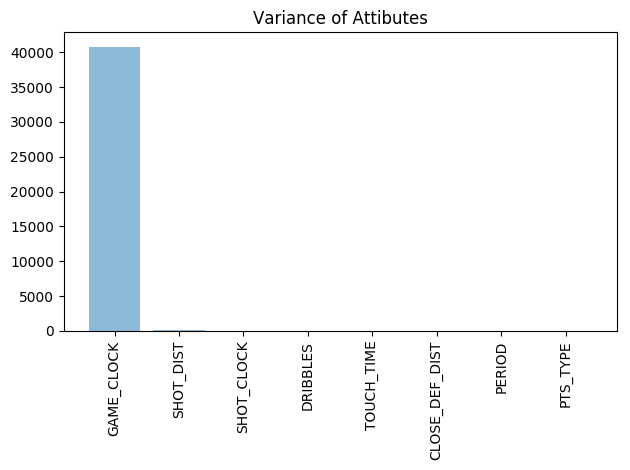

TOP 3 Fetures: GAME_CLOCK, SHOT_DIST, SHOT_CLOCK


In [38]:
var_attributes = np.var(X, axis=0)
indices_var = np.argsort(var_attributes)[::-1]
display(var_attributes[indices_var])

plt.title('Variance of Attibutes')
plt.bar(range(var_attributes.shape[0]), 
        var_attributes[indices_var], 
        align='center', 
        alpha=0.5)
plt.xticks(range(var_attributes.shape[0]),
           X_train.columns.values[indices_var],
           rotation=90)
plt.tight_layout()
plt.show()
print(f'TOP 3 Fetures: {X_train.columns.values[indices_var[0]]}, {X_train.columns.values[indices_var[1]]}, {X_train.columns.values[indices_var[2]]}')

# Correlation Heat Map of Attirbutes

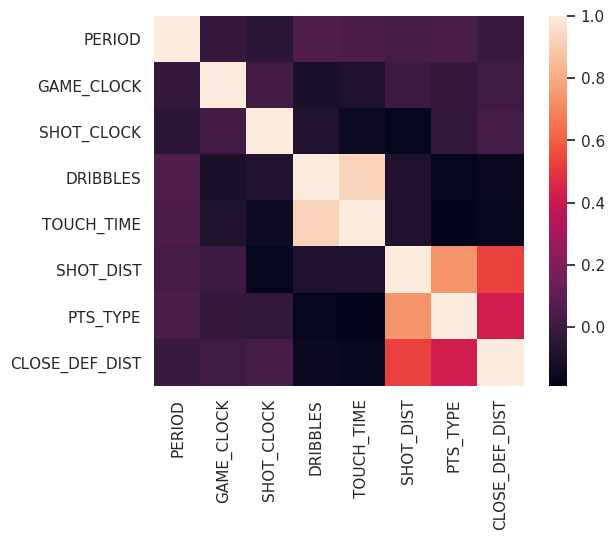

<Figure size 1000x800 with 0 Axes>

In [39]:
# Z-normalize data
# sc = StandardScaler()
# Z = sc.fit_transform(X)
# Estimate the correlation matrix
R = np.dot(X_std.T, X_std) / X_std.shape[0]

sns.set(font_scale=1.0)

ticklabels = [s for s in X.columns]

hm = sns.heatmap(
    R,
    cbar = True,
    square = True,
    yticklabels = ticklabels,
    xticklabels = ticklabels
)

plt.figure(figsize=(10, 8))
plt.tight_layout()
# plt.savefig('./output/fig-wine-corr.png', dpi = 300)
plt.show()

sns.reset_orig()

# Select Features

The table shows the result of each feature selection. Number '5' in the column of PERIOD of first row means PERIOD is 6th (important) feature in descending order. Here I sum all the number through the same column in the last row 'sum'. I select the features which have smallest 3 number as output.

In [40]:
indices_all = pd.DataFrame(index=['indices_f', 'indices_l', 'indices_var'], columns=X.columns)

for idx, idx_pack in enumerate(zip(indices_f, indices_l, indices_var)):
    idx_f, idx_l, idx_var = idx_pack
    indices_all.loc['indices_f'][idx_f] = idx
    indices_all.loc['indices_l'][idx_l] = idx
    indices_all.loc['indices_var'][idx_var] = idx
    
# display(indices_all)
indices_all.loc['indeice_sum'] = indices_all.sum(axis=0)
display(indices_all)

indices_sort = np.argsort(indices_all.loc['indeice_sum'].values)
columns_sel = indices_all.columns.values[indices_sort][:3]
print(f'Selected 3 features: {columns_sel}')

X_train_std = X_train_std[columns_sel]
X_test_std = X_test_std[columns_sel]

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
indices_f,5,0,2,6,4,1,7,3
indices_l,7,4,3,6,2,1,5,0
indices_var,6,0,2,3,4,1,7,5
indeice_sum,18,4,7,15,10,3,19,8


Selected 3 features: ['SHOT_DIST' 'GAME_CLOCK' 'SHOT_CLOCK']


# Visualize in 3D

I try to visualize the data distribution in 3D plot according to selected 3 features. It seems that the data points can be seperate in to 2 cluster along SHOT_DIST. However, in general, two kinds of class seems to be a mess.

<IPython.core.display.Javascript object>


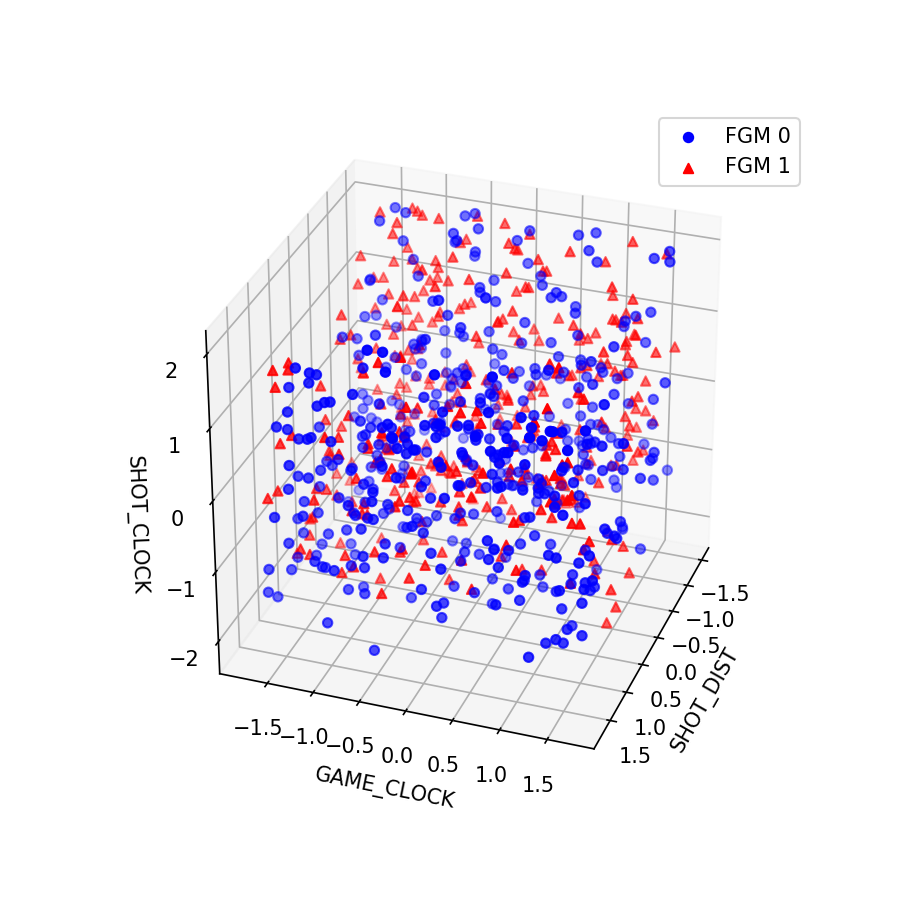

In [54]:
cols_sel = columns_sel
X_train_smaple = X_train_std.sample(frac=0.01, random_state=1, replace=False)
l0 = X_train_smaple.loc[y_train['FGM'] == 0]
l1 = X_train_smaple.loc[y_train['FGM'] == 1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l0[cols_sel[0]], l0[cols_sel[1]], l0[cols_sel[2]], 
           marker='o', color='blue', label='FGM 0')
ax.scatter(l1[cols_sel[0]], l1[cols_sel[1]], l1[cols_sel[2]], 
           marker='^', color='red', label='FGM 1')
ax.set_xlabel(columns_sel[0])
ax.set_ylabel(columns_sel[1])
ax.set_zlabel(columns_sel[2])
ax.legend()
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()

# Split Validation Set

Here I use module 'gridSearchCV' which has implemented K-Fold algorithm. I use 5 fold cross validation and the scoring is accuracy(correct samples/ validation set).

# GridSearchCV

Here are some utilty functions. 

### 'grid_tune' function 

Apply the model and parameters, search for the best paramter set for the model and, show the score of cross validation in 5 folds. 

### 'record' Function 

Store the current model and compare with the performance of the best model. Record the highest record ever and store the best model.

### 'best_predict' Function 

Load the best model and generate the prediction.

In [42]:
load_saved = True

global_best_score = 0
global_best_model = None
global_best_cv_results = None
global_best_model_name = 'None'

def grid_tune(clf, params, name, scoring=None, is_show=True):
    if(not load_saved):
        gs = GridSearchCV(clf, params, scoring=scoring, cv=5, n_jobs=parallel_procs, return_train_score=True)
        gs.fit(X_train_std.values, y_train.values.ravel())

        cv_results = pd.DataFrame(gs.cv_results_)
        best_score = gs.best_score_
        best_param = gs.best_params_
        best_model = clone(gs.best_estimator_)
        best_model.fit(X_train_std.values, y_train.values.ravel())
    else:
        best_model = load(f'models/{name}.joblib')
        cv_results = pd.read_csv(f'cvs/{name}-cv.csv', index_col=False)
        cv_results.drop(cv_results.columns[[0]], axis=1, inplace=True)
        best_param = best_model.get_params()
        
        score_sorted_idxs = np.argsort(cv_results[['mean_test_score']].values.ravel())[::-1]
#         print(score_sorted_idxs)
#         print(score_sorted_idxs[0])
        best_score = cv_results.loc[score_sorted_idxs[0], ['mean_test_score']].values[0]
        
    if(is_show):
        display(cv_results)
        print(f'Mean Validation Score of Best: {best_score}')
        print(f'Params of Best: {best_param}')
    
    return best_model, best_score, best_param, cv_results

def record(model, score, cv_results, name):
    print(f'Recording Model: {name}')
    global global_best_score
    global global_best_model
    global global_best_cv_results
    global global_best_model_name
    
    if(global_best_model == None and global_best_score == 0):
        print(f'Init Best Model: {name}, CV: {score}')
        global_best_score = score
        global_best_model = model
        global_best_cv_results = cv_results
        global_best_model_name = name
        
        dump(model, f'models/{name}.joblib')
        dump(model, f'models/best.joblib')
        cv_results.to_csv('cvs/best-cv.csv')
        cv_results.to_csv(f'cvs/{name}-cv.csv')
        
    else:
        if(global_best_score > score):
            print(f'Keep Best Model: {global_best_model_name}, CV: {global_best_score}')
            dump(model, f'models/{name}.joblib')
            cv_results.to_csv(f'cvs/{name}-cv.csv')
            
        else:
            print(f'Update Best Model: {name}, CV: {score}')
            global_best_score = score
            global_best_model = model
            global_best_cv_results = cv_results
            global_best_model_name = name
            
            dump(model, f'models/{name}.joblib')
            dump(model, f'models/best.joblib')
            cv_results.to_csv('cvs/best-cv.csv')
            cv_results.to_csv(f'cvs/{name}-cv.csv')

# Pair: (name, model, params)
def model_search(model_param_list):
    for pair in model_param_list:
        model, score, param = grid_tune(pair[1], pair[2])
        record(model, score, pair[0])
        
    best_predict()
        
def best_predict():
    best = load('models/best.joblib')
    print(f'Best Model')
    print(f'{type(best).__name__}')
    print(f'Parameters')
    print(best.get_params())
    print(f'Training Acc')
    print(f'{accuracy_score(y_train, best.predict(X_train_std.values))}')
    print(f'CV 5 folds Acc')
    cv_score = cross_val_score(clone(best), X_train_std.values, y_train.values.ravel(), cv=5)
    print(f'Mean {sum(cv_score) / len(cv_score)}')
    print(f'{cv_score}')
    
    pred_best = pd.DataFrame(best.predict(X_test_std))
    pred_best.to_csv('models/best.csv', index=False, header=False)
    
    return pred_best

# Ridge Classifier

Here I plot the error curve for Ridge Classifier to see whether alpha 1e-9 is overfitted or not.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_solver,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.270673,0.083190,0.019293,0.006518,1.000000e+05,lsqr,"{'alpha': 100000, 'solver': 'lsqr'}",0.592968,0.591720,0.593469,...,0.592086,0.002963,15,0.592915,0.591653,0.591945,0.590924,0.593709,0.592229,0.000977
1,0.260587,0.046242,0.011110,0.009437,5.000000e+04,lsqr,"{'alpha': 50000, 'solver': 'lsqr'}",0.597458,0.602857,0.601166,...,0.600833,0.004537,3,0.602157,0.599889,0.601055,0.599350,0.602105,0.600911,0.001139
2,0.320680,0.057684,0.009938,0.007862,2.000000e+04,lsqr,"{'alpha': 20000, 'solver': 'lsqr'}",0.598741,0.605190,0.600816,...,0.602360,0.004419,1,0.602770,0.601347,0.602251,0.600224,0.603315,0.601981,0.001092
3,0.295435,0.036074,0.013800,0.016777,1.000000e+04,lsqr,"{'alpha': 10000, 'solver': 'lsqr'}",0.596642,0.602974,0.600466,...,0.600879,0.004681,2,0.601983,0.600399,0.601318,0.599262,0.602134,0.601019,0.001071
4,0.308756,0.038044,0.004932,0.000763,5.000000e+03,lsqr,"{'alpha': 5000, 'solver': 'lsqr'}",0.596875,0.602799,0.599300,...,0.600494,0.004851,4,0.601429,0.600079,0.600720,0.598840,0.601740,0.600562,0.001036
5,0.189135,0.037742,0.006249,0.002956,1.000000e+03,lsqr,"{'alpha': 1000, 'solver': 'lsqr'}",0.595884,0.603032,0.599067,...,0.600016,0.004849,5,0.600335,0.599525,0.600181,0.597921,0.601551,0.599903,0.001187
6,0.210437,0.056519,0.012363,0.009409,5.000000e+02,lsqr,"{'alpha': 500, 'solver': 'lsqr'}",0.595417,0.602974,0.598892,...,0.599841,0.005065,6,0.600423,0.599656,0.600093,0.597732,0.601522,0.599885,0.001241
7,0.250139,0.046492,0.006759,0.002213,1.000000e+02,lsqr,"{'alpha': 100, 'solver': 'lsqr'}",0.595067,0.602741,0.598601,...,0.599515,0.004996,7,0.600583,0.599510,0.600108,0.597717,0.601478,0.599879,0.001258
8,0.224949,0.045688,0.015293,0.016915,5.000000e+01,lsqr,"{'alpha': 50, 'solver': 'lsqr'}",0.594892,0.602741,0.598659,...,0.599492,0.005026,8,0.600569,0.599598,0.600108,0.597703,0.601522,0.599900,0.001268
9,0.203329,0.046284,0.003779,0.000475,1.000000e+01,lsqr,"{'alpha': 10, 'solver': 'lsqr'}",0.594834,0.602741,0.598717,...,0.599480,0.005079,9,0.600598,0.599612,0.600050,0.597717,0.601478,0.599891,0.001253


Mean Validation Score of Best: 0.6023603223286026
Params of Best: {'alpha': 20000, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'lsqr', 'tol': 0.001}
Recording Model: ridge
Init Best Model: ridge, CV: 0.6023603223286026
Recording Model: ridge
Update Best Model: ridge, CV: 0.6023603223286026


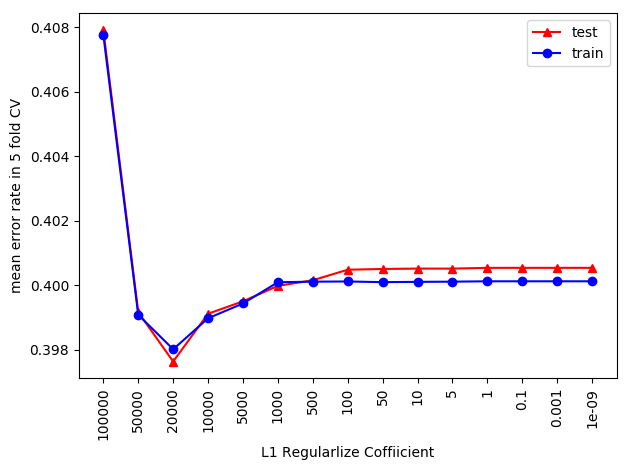

In [43]:
params = [{
              'alpha': [100000, 50000, 20000, 10000, 5000, 1000, 500, 100, 50, 10, 5, 1, 0.1, 0.001, 1e-9],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
          }]
model, score, param, cv_results = grid_tune(RidgeClassifier(), params, 'ridge')
record(model, score, cv_results, 'ridge')

# search_model_list = [('ridge', RidgeClassifier(), params)]
# model_search(search_model_list)

params[0]['solver'] = [param['solver']]
model, score, param, cv_results = grid_tune(RidgeClassifier(), params, 'ridge', is_show=False)
record(model, score, cv_results, 'ridge')
cv_results = pd.DataFrame(cv_results)

cv_results[['mean_test_error_rate']] = 1 - cv_results[['mean_test_score']]
cv_results[['mean_train_error_rate']] = 1 - cv_results[['mean_train_score']]

plt.plot(cv_results.loc[:, ['mean_test_error_rate']], color='red', marker='^', label='test')
plt.plot(cv_results.loc[:, ['mean_train_error_rate']], color='blue', marker='o', label='train')
plt.xlabel('L1 Regularlize Coffiicient')
# plt.ylabel('mean score of CV 5 fold')
plt.ylabel('mean error rate in 5 fold CV')
plt.legend()
    
plt.xticks(range(len(params[0]['alpha'])), params[0]['alpha'], rotation=90)
plt.tight_layout()
plt.savefig('fig/ridge-error-curve.png')
plt.show()

# Random Forest Classifier

The accuracy of 500 estimators is very close 200 estimator. It's almost useless that add more estimators.

In [44]:
params = [{
              'n_estimators': [100, 200, 500], 
              'criterion': ['gini', 'entropy'],
              'n_jobs': [parallel_procs]
          }]

model, score, param, cv_results = grid_tune(RandomForestClassifier(), params, 'forest')
record(model, score, cv_results, 'forest')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.940918,0.421644,2.415581,0.677785,gini,100,-1,"{'criterion': 'gini', 'n_estimators': 100, 'n_...",0.560375,0.558601,...,0.558932,0.001712,6,0.998936,0.998732,0.998732,0.998819,0.99895,0.998834,0.000095
1,18.677651,0.678574,2.626938,0.778616,gini,200,-1,"{'criterion': 'gini', 'n_estimators': 200, 'n_...",0.562941,0.559242,...,0.560017,0.001733,3,0.998950,0.998732,0.998746,0.998819,0.99895,0.998840,0.000095
2,37.896489,0.229458,1.807076,0.432600,gini,500,-1,"{'criterion': 'gini', 'n_estimators': 500, 'n_...",0.561950,0.562391,...,0.560845,0.001583,2,0.998950,0.998732,0.998746,0.998819,0.99895,0.998840,0.000095
3,15.327517,0.925555,2.700000,0.255464,entropy,100,-1,"{'criterion': 'entropy', 'n_estimators': 100, ...",0.557752,0.560233,...,0.559294,0.001186,5,0.998950,0.998732,0.998717,0.998819,0.99895,0.998834,0.000101
4,27.448627,0.538178,1.760456,0.418978,entropy,200,-1,"{'criterion': 'entropy', 'n_estimators': 200, ...",0.561891,0.559650,...,0.559609,0.001601,4,0.998950,0.998732,0.998746,0.998819,0.99895,0.998840,0.000095
5,45.656666,0.247648,0.851508,0.028950,entropy,500,-1,"{'criterion': 'entropy', 'n_estimators': 500, ...",0.560667,0.563207,...,0.560903,0.001350,1,0.998950,0.998732,0.998746,0.998819,0.99895,0.998840,0.000095


Mean Validation Score of Best: 0.5609030798474653
Params of Best: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Recording Model: forest
Keep Best Model: ridge, CV: 0.6023603223286026


# Gaussian Naive Bayes

In [45]:
params = [{
              'var_smoothing': [1e-9, 1e-6, 1e-3, 1, 10]
         }]

model, score, param, cv_results = grid_tune(GaussianNB(), params, 'gaussian')
record(model, score, cv_results, 'gaussian')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027536,0.017524,0.004817,0.002948,1.000000e-09,{'var_smoothing': 1e-09},0.597808,0.602449,0.600583,0.609563,...,0.600949,0.005100,1,0.601939,0.600662,0.601799,0.599146,0.602746,0.601258,0.001248
1,0.024137,0.005354,0.004426,0.000795,1.000000e-06,{'var_smoothing': 1e-06},0.597808,0.602449,0.600583,0.609563,...,0.600949,0.005100,1,0.601939,0.600662,0.601799,0.599146,0.602746,0.601258,0.001248
2,0.023032,0.006474,0.004216,0.001017,1.000000e-03,{'var_smoothing': 0.001},0.597749,0.602274,0.600641,0.609563,...,0.600903,0.005112,3,0.601968,0.600574,0.601799,0.599160,0.602703,0.601241,0.001245
3,0.021666,0.007391,0.003596,0.001246,1.000000e+00,{'var_smoothing': 1},0.597691,0.597551,0.597551,0.604490,...,0.597812,0.004029,4,0.598848,0.596872,0.597469,0.596114,0.598752,0.597611,0.001062
4,0.022612,0.006580,0.004309,0.001265,1.000000e+01,{'var_smoothing': 10},0.546266,0.546239,0.546239,0.546239,...,0.546244,0.000011,5,0.546239,0.546246,0.546246,0.546246,0.546246,0.546244,0.000003


Mean Validation Score of Best: 0.6009492600669379
Params of Best: {'priors': None, 'var_smoothing': 1e-09}
Recording Model: gaussian
Keep Best Model: ridge, CV: 0.6023603223286026


# KNN

The accuracy of 1000 neighbors is very close 500 neighbors. It's almost useless that add more neighbors

In [46]:
params = [{
              'n_neighbors': [5, 100, 200, 500, 1000],
              'weights': ['uniform', 'distance'],
              'n_jobs': [parallel_procs]
         }]

model, score, param, cv_results = grid_tune(KNeighborsClassifier(), params, 'knn')
record(model, score, cv_results, 'knn')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.349055,0.291033,0.539876,0.320438,-1,5,uniform,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'u...",0.545391,0.552770,...,0.549463,0.002602,9,0.709723,0.704727,0.706433,0.708911,0.705048,0.706968,0.002018
1,0.471764,0.187881,0.695020,0.262439,-1,5,distance,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd...",0.542242,0.546706,...,0.545463,0.001990,10,0.998950,0.998732,0.998746,0.998819,0.998950,0.998840,0.000095
2,0.039884,0.002944,1.086952,0.179424,-1,100,uniform,"{'n_jobs': -1, 'n_neighbors': 100, 'weights': ...",0.600315,0.609563,...,0.605451,0.004094,7,0.613980,0.612469,0.613081,0.611405,0.615880,0.613363,0.001512
3,0.067864,0.047305,1.846276,0.486399,-1,100,distance,"{'n_jobs': -1, 'n_neighbors': 100, 'weights': ...",0.595534,0.603324,...,0.601008,0.004052,8,0.998950,0.998732,0.998746,0.998819,0.998950,0.998840,0.000095
4,0.137284,0.075768,2.759456,0.503259,-1,200,uniform,"{'n_jobs': -1, 'n_neighbors': 200, 'weights': ...",0.602705,0.609796,...,0.607177,0.004099,5,0.612026,0.610283,0.610968,0.609904,0.611930,0.611022,0.000852
5,0.164901,0.026526,3.347804,0.539933,-1,200,distance,"{'n_jobs': -1, 'n_neighbors': 200, 'weights': ...",0.600723,0.608047,...,0.605579,0.004859,6,0.998950,0.998732,0.998746,0.998819,0.998950,0.998840,0.000095
6,0.190208,0.060310,6.051790,0.470086,-1,500,uniform,"{'n_jobs': -1, 'n_neighbors': 500, 'weights': ...",0.603638,0.611195,...,0.608179,0.004118,2,0.611327,0.609219,0.609598,0.608009,0.610414,0.609713,0.001119
7,0.318915,0.081077,6.817060,0.685684,-1,500,distance,"{'n_jobs': -1, 'n_neighbors': 500, 'weights': ...",0.603172,0.610787,...,0.608389,0.004471,1,0.998950,0.998732,0.998746,0.998819,0.998950,0.998840,0.000095
8,0.278879,0.046182,8.875880,0.853178,-1,1000,uniform,"{'n_jobs': -1, 'n_neighbors': 1000, 'weights':...",0.603405,0.610787,...,0.607387,0.004098,4,0.608819,0.607528,0.608592,0.607163,0.608621,0.608145,0.000667
9,0.160875,0.034723,10.031969,0.586136,-1,1000,distance,"{'n_jobs': -1, 'n_neighbors': 1000, 'weights':...",0.602530,0.610904,...,0.607515,0.004252,3,0.998950,0.998732,0.998746,0.998819,0.998950,0.998840,0.000095


Mean Validation Score of Best: 0.6083894065375329
Params of Best: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 500, 'p': 2, 'weights': 'distance'}
Recording Model: knn
Update Best Model: knn, CV: 0.6083894065375329


# MLPClassifier

The classifier of 2 hidden layers is better than 3 hidden layers. It would overfit while adding more layers.

In [47]:
params = [{
              'hidden_layer_sizes': [(100), (100, 100), (100, 100, 100)], 
              'solver': ['adam'],
              'learning_rate': ['adaptive'],
              'learning_rate_init': [0.001, 0.1, 1]
          }]

model, score, param, cv_results = grid_tune(MLPClassifier(), params, 'mlp')
record(model, score, cv_results, 'mlp')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,481.863355,66.714043,0.486861,0.060265,100,adaptive,0.001,adam,"{'hidden_layer_sizes': 100, 'learning_rate': '...",0.604688,...,0.610045,0.004553,2,0.611501,0.609700,0.610399,0.609160,0.610662,0.610284,0.000805
1,156.808821,29.943718,0.464397,0.043944,100,adaptive,0.100,adam,"{'hidden_layer_sizes': 100, 'learning_rate': '...",0.597808,...,0.579620,0.027380,4,0.602055,0.546246,0.608883,0.592295,0.546246,0.579145,0.027375
2,162.850738,43.747986,0.454751,0.040101,100,adaptive,1.000,adam,"{'hidden_layer_sizes': 100, 'learning_rate': '...",0.546266,...,0.509254,0.045309,7,0.546239,0.453754,0.546246,0.453754,0.546246,0.509248,0.045310
3,779.575193,67.878982,0.537669,0.081245,"(100, 100)",adaptive,0.001,adam,"{'hidden_layer_sizes': (100, 100), 'learning_r...",0.605387,...,0.610395,0.003993,1,0.611618,0.610297,0.610516,0.609889,0.612149,0.610894,0.000849
4,424.718975,87.538701,1.014408,0.124507,"(100, 100)",adaptive,0.100,adam,"{'hidden_layer_sizes': (100, 100), 'learning_r...",0.600548,...,0.557101,0.021724,6,0.606647,0.546246,0.546246,0.546246,0.546246,0.558326,0.024161
5,830.879829,125.703561,0.397631,0.241254,"(100, 100)",adaptive,1.000,adam,"{'hidden_layer_sizes': (100, 100), 'learning_r...",0.453734,...,0.509242,0.045311,9,0.453761,0.453754,0.546246,0.546246,0.546246,0.509250,0.045310
6,926.618671,179.612034,0.329770,0.315665,"(100, 100, 100)",adaptive,0.001,adam,"{'hidden_layer_sizes': (100, 100, 100), 'learn...",0.603638,...,0.609381,0.004296,3,0.617172,0.610297,0.611595,0.610166,0.611901,0.612226,0.002566
7,390.268295,24.876159,1.001080,0.098478,"(100, 100, 100)",adaptive,0.100,adam,"{'hidden_layer_sizes': (100, 100, 100), 'learn...",0.546266,...,0.558268,0.024044,5,0.546239,0.546246,0.607659,0.546246,0.546246,0.558527,0.024566
8,667.112345,123.908497,0.263770,0.114565,"(100, 100, 100)",adaptive,1.000,adam,"{'hidden_layer_sizes': (100, 100, 100), 'learn...",0.546266,...,0.509254,0.045309,7,0.546239,0.453754,0.546246,0.546246,0.453754,0.509248,0.045310


Mean Validation Score of Best: 0.6103952140499819
Params of Best: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Recording Model: mlp
Update Best Model: mlp, CV: 0.6103952140499819


# SVC

Since sigmoid kernel is worse than rbf and polynomial kernel in performance, ignore them.

In [48]:
params = [
          {
              'C': [1, 5, 10], 
              'kernel': ['rbf'], 
          },
          {
              'C': [1, 5, 10], 
              'kernel': ['poly'],
              'degree': [3, 5]
          }
]

model, score, param, cv_results = grid_tune(SVC(), params, 'svc')
record(model, score, cv_results, 'svc')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,444.428384,9.138174,40.173294,0.668735,1,rbf,NaN,"{'C': 1, 'kernel': 'rbf'}",0.604396,0.610437,...,0.608028,0.003898,2,0.608542,0.607673,0.608461,0.607542,0.608752,0.608194,0.000490
1,546.492099,7.445679,40.956586,0.961835,5,rbf,NaN,"{'C': 5, 'kernel': 'rbf'}",0.604163,0.610262,...,0.608051,0.003852,1,0.609359,0.608169,0.609029,0.607178,0.609000,0.608547,0.000789
2,674.858989,17.083751,32.622468,2.715994,10,rbf,NaN,"{'C': 10, 'kernel': 'rbf'}",0.603813,0.610029,...,0.607993,0.004172,3,0.609606,0.608256,0.609291,0.607586,0.609306,0.608809,0.000764
3,362.238960,9.798940,13.780489,0.934552,1,poly,3.0,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.603871,0.609271,...,0.606640,0.004519,4,0.607507,0.606551,0.606915,0.605108,0.607819,0.606780,0.000946
4,481.511186,11.771790,15.402920,0.904531,1,poly,5.0,"{'C': 1, 'degree': 5, 'kernel': 'poly'}",0.593843,0.592420,...,0.594430,0.001725,9,0.596122,0.591114,0.594904,0.595239,0.598198,0.595116,0.002306
5,502.328751,10.712481,14.925684,0.429021,5,poly,3.0,"{'C': 5, 'degree': 3, 'kernel': 'poly'}",0.603930,0.609213,...,0.606640,0.004505,4,0.607347,0.606463,0.606915,0.605137,0.607805,0.606733,0.000914
6,1750.428582,294.131990,8.172237,0.860379,5,poly,5.0,"{'C': 5, 'degree': 5, 'kernel': 'poly'}",0.594018,0.592770,...,0.594734,0.001804,8,0.596254,0.591318,0.594889,0.595385,0.598227,0.595215,0.002257
7,449.546759,53.095522,8.412147,0.636100,10,poly,3.0,"{'C': 10, 'degree': 3, 'kernel': 'poly'}",0.603930,0.609271,...,0.606605,0.004524,6,0.607347,0.606434,0.606901,0.605108,0.607761,0.606710,0.000915
8,4440.111005,220.234166,7.733246,0.190649,10,poly,5.0,"{'C': 10, 'degree': 5, 'kernel': 'poly'}",0.594018,0.592711,...,0.594769,0.001853,7,0.596254,0.591347,0.594933,0.595385,0.598184,0.595220,0.002234


Mean Validation Score of Best: 0.6080512180615969
Params of Best: {'C': 5, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Recording Model: svc
Keep Best Model: mlp, CV: 0.6103952140499819


# Select Best Model

Finally, the MLP classifier is the best whose 5 fold cross validation accuracy is about 61%. The MLP classifier has 2 hidden layers and each layer has 100 neurons.

In [49]:
pred_best = best_predict()
display(pred_best)

Best Model
MLPClassifier
Parameters
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Training Acc
0.6113281477767023
CV 5 folds Acc
Mean 0.6104885573910216
[0.60620372 0.61212828 0.61072886 0.61597668 0.60740525]


,0
0,1
1,0
2,1
3,1
4,1
5,0
6,0
7,0
8,0
9,0


# Error Curve

According to the following error curve, the error rate of the 1 and 3 hidden layers MLP classifier are higher. The MLP classifier which has 2 hidden layers is the best. It seems that it doesn't overfit the training data.

,param_hidden_layer_sizes,mean_train_score,mean_test_score,mean_train_error_rate,mean_test_error_rate
0,100,0.610284,0.610045,0.389716,0.389955
3,"(100, 100)",0.610894,0.610395,0.389106,0.389605
6,"(100, 100, 100)",0.612226,0.609381,0.387774,0.390619


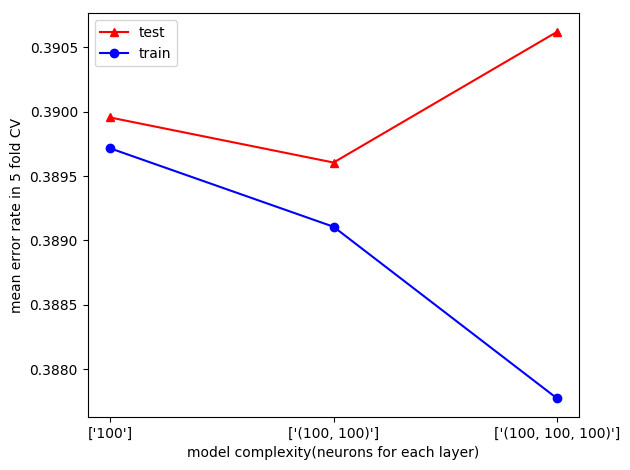

In [50]:
cv_results = pd.read_csv(f'cvs/best-cv.csv', index_col=False)
cv_results.drop(cv_results.columns[[0]], axis=1, inplace=True)

cv_results[['mean_test_error_rate']] = 1 - cv_results[['mean_test_score']]
cv_results[['mean_train_error_rate']] = 1 - cv_results[['mean_train_score']]

display(cv_results.loc[cv_results['param_learning_rate_init'] == 0.001, 
                      ['param_hidden_layer_sizes', 'mean_train_score', 'mean_test_score', 'mean_train_error_rate', 'mean_test_error_rate']])

plt.plot(cv_results.loc[cv_results['param_learning_rate_init'] == 0.001, ['mean_test_error_rate']], 
         color='red', marker='^', label='test')
plt.plot(cv_results.loc[cv_results['param_learning_rate_init'] == 0.001, ['mean_train_error_rate']], 
         color='blue', marker='o', label='train')
plt.xlabel('model complexity(neurons for each layer)')
plt.ylabel('mean error rate in 5 fold CV')
plt.legend()
    
plt.xticks(np.arange(0, 9, step=3), 
           cv_results.loc[cv_results['param_learning_rate_init'] == 0.001, ['param_hidden_layer_sizes']].values, 
           rotation=0)
plt.tight_layout()
plt.savefig('fig/best-error-curve.png')
plt.show()